In [ ]:
!pip install tensorflow==2.12.0
!pip install -U imbalanced-learn
import tensorflow as tf
print(tf.__version__)


2.12.0


# Imports

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix, precision_recall_fscore_support, roc_auc_score
from tensorflow import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Conv1D, Flatten, Conv2D
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

In [ ]:
# import warnings

# warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
rawData = pd.read_csv('/content/drive/MyDrive/Power_Theft_Detection/Dataset/data.csv')
# rawData = rawData.iloc[:, -30:]

Mounted at /content/drive


In [ ]:
rawData.columns

Index(['CONS_NO', 'FLAG', '2014/1/1', '2014/1/10', '2014/1/11', '2014/1/12',
       '2014/1/13', '2014/1/14', '2014/1/15', '2014/1/16',
       ...
       '2016/9/28', '2016/9/29', '2016/9/3', '2016/9/30', '2016/9/4',
       '2016/9/5', '2016/9/6', '2016/9/7', '2016/9/8', '2016/9/9'],
      dtype='object', length=1036)

# Data Processing

In [ ]:
rawData = pd.read_csv('/content/drive/MyDrive/Power_Theft_Detection/Dataset/data.csv')
# rawData = rawData.iloc[:, :2].join(rawData.iloc[:, -30:])
# rawData.columns.values[-30:] = [f"day{i}" for i in range(1, 31)]
infoData = pd.DataFrame()
infoData['FLAG'] = rawData['FLAG']
infoData['CONS_NO'] = rawData['CONS_NO']
data = rawData.drop(['FLAG', 'CONS_NO'], axis=1)

dropIndex = data[data.duplicated()].index  # duplicates drop
data = data.drop(dropIndex, axis=0)
infoData = infoData.drop(dropIndex, axis=0)

zeroIndex = data[(data.sum(axis=1) == 0)].index  # zero rows drop
data = data.drop(zeroIndex, axis=0)
infoData = infoData.drop(zeroIndex, axis=0)

# data.columns = pd.to_datetime(data.columns)  # columns reindexing according to dates
# data = data.reindex(sorted(data.columns), axis=1)
cols = data.columns

data.reset_index(inplace=True, drop=True)  # index sorting
infoData.reset_index(inplace=True, drop=True)

data = data.interpolate(method='linear', limit=2,  # filling NaN values
                        limit_direction='both', axis=0).fillna(0)

for i in range(data.shape[0]):  # outliers treatment
    m = data.loc[i].mean()
    st = data.loc[i].std()
    data.loc[i] = data.loc[i].mask(data.loc[i] > (m + 3 * st), other=m + 3 * st)

data.to_csv(r'visualization.csv', index=False, header=True)  # preprocessed data without scaling
# data.to_csv('/content/drive/MyDrive/python/visulaization.csv', index=False)

scale = MinMaxScaler()
scaled = scale.fit_transform(data.values.T).T
mData = pd.DataFrame(data=scaled, columns=data.columns)
# print(mData)
preprData = pd.concat([infoData, mData], axis=1, sort=False)  # Back to initial format
print(preprData)
# preprData.to_csv(r'preprocessedR.csv', index=False, header=True)

       FLAG                           CONS_NO  2014/1/1  2014/1/10  2014/1/11  \
0         1  0387DD8A07E07FDA6271170F86AD9151  0.000000   0.000000   0.000000   
1         1  4B75AC4F2D8434CFF62DB64D0BB43103  0.108235   0.127642   0.142198   
2         1  B32AC8CC6D5D805AC053557AB05F5343  0.077443   0.091330   0.101744   
3         1  EDFC78B07BA2908B3395C4EB2304665E  0.111323   0.131284   0.146255   
4         1  6BCFD78138BC72A9BA1BFB0B79382192  0.141255   0.185367   0.199915   
...     ...                               ...       ...        ...        ...   
40251     0  F1472871E1AFF49D4289564B6377D76C  0.330066   0.272880   0.741561   
40252     0  F3C8BBCD2DC26C1E0249DEEF6A4256B7  0.275157   0.447385   0.402545   
40253     0  A9A0FE83467A680FBFB0DBFC910DF227  0.078565   0.113784   0.218086   
40254     0  D9A6ADA018FA46A55D5438370456AA45  0.417892   0.342429   0.334017   
40255     0  F3406636BAD1E6E0826E8EDDC9A1BF00  0.444454   0.364194   0.355247   

       2014/1/12  2014/1/13

# Data Balancing

In [ ]:
# Drop the 'CONS_NO' column
preprData = preprData.drop('CONS_NO', axis=1)

# Apply SMOTE for data balancing
X = preprData.drop('FLAG', axis=1)  # Features
y = preprData['FLAG']  # Target (labels)

# Instantiate SMOTE to balance the minority class (FLAG = 1)
smote = SMOTE()

# Resampling the data to balance classes
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# class AdaBoostClassifierWithProgress(AdaBoostClassifier):
#     def fit(self, X, y):
#         self.n_estimators_ = self.n_estimators
#         self.staged_predict_proba_ = []
#         self.progress_bar = tqdm(total=self.n_estimators, desc="Training AdaBoost", ncols=100)

#         super().fit(X, y)

#         self.progress_bar.close()
#         return self

#     def _boost(self, iboost, X, y, sample_weight, random_state):
#         self.progress_bar.update(1)
#         return super()._boost(iboost, X, y, sample_weight, random_state)

# # Instantiate the customized AdaBoost classifier with progress tracking
# adaBoost = AdaBoostClassifierWithProgress(n_estimators=100, random_state=42)

# # Train the classifier on the balanced data
# adaBoost.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = adaBoost.predict(X_test)

# # Evaluate the classifier performance
# print(classification_report(y_test, y_pred))

# Combine the resampled data into a DataFrame
balancedData = pd.concat([pd.DataFrame(y_resampled, columns=['FLAG']), pd.DataFrame(X_resampled, columns=X.columns)], axis=1)

# Save the balanced data
balancedData.to_csv(r'balanced_preprocessedR.csv', index=False, header=True)

# Model Training

## Model Paramaneters

In [ ]:
tf.random.set_seed(1234)
epochs_number = 10  # number of epochs for the neural networks
test_set_size = 0.1  # percentage of the test size comparing to the whole dataset
oversampling_flag = 0  # set to 1 to over-sample the minority class
oversampling_percentage = 0.2  # percentage of the minority class after the oversampling comparing to majority class

## Data Loader

In [ ]:
# Definition of functions
def read_data():
    rawData = pd.read_csv('balanced_preprocessedR.csv')

    # Setting the target and dropping the unnecessary columns
    y = rawData[['FLAG']]
    X = rawData.drop(['FLAG'], axis=1)

    print('Normal Consumers:                    ', y[y['FLAG'] == 0].count()[0])
    print('Consumers with Fraud:                ', y[y['FLAG'] == 1].count()[0])
    print('Total Consumers:                     ', y.shape[0])
    print("Classification assuming no fraud:     %.2f" % (y[y['FLAG'] == 0].count()[0] / y.shape[0] * 100), "%")

    # columns reindexing according to dates
    # X.columns = pd.to_datetime(X.columns)
    # X = X.reindex(X.columns, axis=1)

    # Splitting the dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y['FLAG'], test_size=test_set_size, random_state=0)
    print("Test set assuming no fraud:           %.2f" % (y_test[y_test == 0].count() / y_test.shape[0] * 100), "%\n")

    # Oversampling of minority class to encounter the imbalanced learning
    # if oversampling_flag == 1:
    #     over = SMOTE(sampling_strategy=oversampling_percentage, random_state=0)
    #     X_train, y_train = over.fit_resample(X_train, y_train)
    #     print("Oversampling statistics in training set: ")
    #     print('Normal Consumers:                    ', y_train[y_train == 0].count())
    #     print('Consumers with Fraud:                ', y_train[y_train == 1].count())
    #     print("Total Consumers                      ", X_train.shape[0])

    return X_train, X_test, y_train, y_test

## Models

### Artificial Neural Network

In [ ]:
def ANN(X_train, X_test, y_train, y_test):
    print('Artificial Neural Network:')
    # for i in range(4,100,3):
    #     print("Epoch:",i)

    # Model creation
    model = Sequential()
    model.add(Dense(1000, input_dim=1034, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])

    # model.fit(X_train, y_train, validation_split=0, epochs=i, shuffle=True, verbose=0)
    model.fit(X_train, y_train, validation_split=0, epochs=epochs_number, shuffle=True, verbose=1)
    prediction =(model.predict(X_test) > 0.5).astype("int32")
    model.summary()
    results(y_test, prediction, save_folder='/content/drive/MyDrive/Power_Theft_Detection/resultsImages')


### 1D - Convolutional Neural Network

In [ ]:
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np

# Custom callback to track AUC and accuracy per epoch
class MetricsCallback(Callback):
    def __init__(self, X_test, y_test):
        super(MetricsCallback, self).__init__()
        self.X_test = X_test
        self.y_test = y_test
        self.auc_per_epoch = []
        self.accuracy_per_epoch = []

    def on_epoch_end(self, epoch, logs=None):
        # Make predictions at the end of each epoch
        y_pred = (self.model.predict(self.X_test) > 0.5).astype("int32")

        # Calculate AUC and Accuracy
        auc = roc_auc_score(self.y_test, y_pred)
        accuracy = accuracy_score(self.y_test, y_pred) * 100

        # Append metrics to the list
        self.auc_per_epoch.append(auc)
        self.accuracy_per_epoch.append(accuracy)

        print(f'Epoch {epoch+1}: AUC = {auc:.4f}, Accuracy = {accuracy:.2f}%')

def CNN1D(X_train, X_test, y_train, y_test, epochs_number=10):
    print('1D - Convolutional Neural Network:')

    # Transforming the dataset into tensors
    X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)

    # Model creation
    model = Sequential()
    model.add(Conv1D(100, kernel_size=7, input_shape=(1034, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])

    # Instantiate the custom callback to track AUC and accuracy
    metrics_callback = MetricsCallback(X_test, y_test)

    # Train the model with the custom callback
    model.fit(X_train, y_train,
              epochs=epochs_number,
              validation_split=0,
              shuffle=False,
              verbose=1,
              callbacks=[metrics_callback])

    # Get the predictions for the test set
    prediction = (model.predict(X_test) > 0.5).astype("int32")

    # Call the results function with the tracked AUC and accuracy per epoch
    # results_CNN(y_test, prediction, metrics_callback.auc_per_epoch, metrics_callback.accuracy_per_epoch, epochs=epochs_number)
    # results_CNN(y_test, prediction, auc_per_epoch, accuracy_per_epoch, save_folder='/content/drive/MyDrive/Power_Theft_Detection/resultsImages')


    # Return the trained model
    return model


### 2D - Convolutional Neural Network

In [ ]:
def CNN2D(X_train, X_test, y_train, y_test):
    print('2D - Convolutional Neural Network:')

    # Transforming every row of the train set into a 2D array and then into a tensor
    n_array_X_train = X_train.to_numpy()
    n_array_X_train_extended = np.hstack((n_array_X_train, np.zeros(
        (n_array_X_train.shape[0], 2))))  # adding two empty columns in order to make the number of columns
    # an exact multiple of 7
    week = []
    for i in range(n_array_X_train_extended.shape[0]):
        a = np.reshape(n_array_X_train_extended[i], (-1, 7, 1))
        week.append(a)
    X_train_reshaped = np.array(week)

    # Transforming every row of the train set into a 2D array and then into a tensor
    n_array_X_test = X_test.to_numpy()  # X_test to 2D - array
    n_array_X_train_extended = np.hstack((n_array_X_test, np.zeros((n_array_X_test.shape[0], 2))))
    week2 = []
    for i in range(n_array_X_train_extended.shape[0]):
        b = np.reshape(n_array_X_train_extended[i], (-1, 7, 1))
        week2.append(b)
    X_test_reshaped = np.array(week2)

    input_shape = (1, 148, 7, 1)  # input shape of the tensor

    # Model creation
    model = Sequential()
    model.add(Conv2D(kernel_size=(7, 3), filters=32, input_shape=input_shape[1:], activation='relu',
                     data_format='channels_last'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
    # model.summary()
    #     model.fit(X_train_reshaped, y_train, validation_split=0.1, epochs=i, shuffle=False, verbose=0)
    model.fit(X_train_reshaped, y_train, validation_split=0.1, epochs=epochs_number, shuffle=False, verbose=1)

    # prediction = model.predict_classes(X_test)
    prediction = (model.predict(X_test_reshaped) > 0.5).astype("int32")
    model.summary()
    results(y_test, prediction, save_folder='/content/drive/MyDrive/Power_Theft_Detection/resultsImages')
    return model


### Logistic Regression

In [ ]:
def LR(X_train, X_test, y_train, y_test):
    print('Logistic Regression:')
    '''
    # Parameters selection
    param_grid = {'C': [0.1,1,10,100],'solver': ['newton-cg', 'lbfgs']}
    grid = GridSearchCV(LogisticRegression(max_iter=1000,random_state=0), param_grid=param_grid, n_jobs=-1)
    grid.fit(X_train, y_train)
    df = pd.DataFrame(grid.cv_results_)
    print(df[['param_C', 'param_solver', 'mean_test_score', 'rank_test_score']])
    '''
    model = LogisticRegression(C=1000, max_iter=1000, n_jobs=-1, solver='newton-cg')
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    results(y_test, prediction, save_folder='/content/drive/MyDrive/Power_Theft_Detection/resultsImages')


### Decision Tree

In [ ]:
def DT(X_train, X_test, y_train, y_test):
    print('Decision Tree:')
    model = DecisionTreeClassifier(random_state=0)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    results(y_test, prediction, save_folder='/content/drive/MyDrive/Power_Theft_Detection/resultsImages')


### Random Forest

In [ ]:
def RF(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.decomposition import PCA
    from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, precision_recall_fscore_support, roc_auc_score, confusion_matrix
    from sklearn.model_selection import RandomizedSearchCV
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Reduce dimensionality with PCA (adjust n_components based on your dataset)
    pca = PCA(n_components=10)  # Change n_components to fit your data
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Parameter grid for RandomizedSearchCV
    param_dist = {
        'n_estimators': [50, 100],               # Fewer trees for faster performance
        'max_depth': [5, 10, None],              # Limit tree depth
        'min_samples_split': [2, 10],            # Minimum samples to split a node
        'min_samples_leaf': [1, 5],              # Minimum samples at a leaf node
        'max_features': ['sqrt', 'log2']         # Use 'sqrt' or 'log2' for feature selection
    }

    # Instantiate the RandomForestClassifier
    model = RandomForestClassifier(random_state=0, n_jobs=-1)

    # Use RandomizedSearchCV to tune hyperparameters quickly
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, random_state=0, n_jobs=-1)
    random_search.fit(X_train_pca, y_train)

    # Get the best estimator
    best_model = random_search.best_estimator_

    # Train the model with the best hyperparameters
    best_model.fit(X_train_pca, y_train)

    # Predict using the test data
    prediction = best_model.predict(X_test_pca)

    # Evaluate the results using the results function
    results(y_test, prediction, save_folder='/content/drive/MyDrive/Power_Theft_Detection/resultsImages')

    # Return the best model
    return best_model

### Support Vector Machine

In [ ]:
# import time
# from sklearn.svm import SVC
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score

# def SVM(X_train, X_test, y_train, y_test):
#     # Scale the data
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Track the time for model fitting
#     start_time = time.time()

#     # Use a linear kernel for faster training with verbose mode to track progress
#     model = SVC(kernel='linear', random_state=0, verbose=True)
#     print("Training started...")

#     # Fit the model
#     model.fit(X_train_scaled, y_train)

#     # Log the time taken
#     training_duration = time.time() - start_time
#     print(f"Training completed in {training_duration:.2f} seconds.")

#     # Make predictions
#     prediction = model.predict(X_test_scaled)

#     # Evaluate the model
#     print(f"Accuracy: {results(y_test, prediction)}")

# # Call your function with your data
# # SVM(X_train, X_test, y_train, y_test)


### XGBoost

In [ ]:
def XGB(X_train, X_test, y_train, y_test):
    # import XGBClassifier
    from xgboost import XGBClassifier

    # declare parameters
    params = {
                'objective':'binary:logistic',
                'max_depth': 4,
                'alpha': 10,
                'learning_rate': 1.0,
                'n_estimators':100
            }
    # instantiate the classifier
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    results(y_test, prediction, save_folder='/content/drive/MyDrive/Power_Theft_Detection/resultsImages')

    return model
# fit the classifier to the training data
# xgb_clf.fit(X_train, y_train)

## Results

In [ ]:
import os  # Importing os to handle folder paths

def results(y_test, prediction, save_folder=None):
    # Calculate metrics
    accuracy = 100 * accuracy_score(y_test, prediction)
    rmse = mean_squared_error(y_test, prediction, squared=False)
    mae = mean_absolute_error(y_test, prediction)
    f1 = 100 * precision_recall_fscore_support(y_test, prediction, average='weighted')[2]  # Weighted F1 score
    auc = 100 * roc_auc_score(y_test, prediction)

    # Print metrics
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"F1 Score (Weighted): {f1:.2f}%")
    print(f"AUC: {auc:.2f}%")

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, prediction)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})

    # Add labels to the plot
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)

    # Ensure the plot is displayed properly
    plt.xticks(ticks=[0.5, 1.5], labels=['Normal (0)', 'Fraud (1)'], fontsize=12)
    plt.yticks(ticks=[0.5, 1.5], labels=['Normal (0)', 'Fraud (1)'], fontsize=12, rotation=0)

    # Save the confusion matrix plot as a PDF
    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        cm_pdf_path = os.path.join(save_folder, 'confusion_matrix.pdf')
        plt.savefig(cm_pdf_path, format='pdf')

    plt.show()

    # Bar plot for the metrics
    metrics = ['Accuracy', 'RMSE', 'MAE', 'F1 Score', 'AUC']
    values = [accuracy, rmse, mae, f1, auc]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=metrics, y=values, palette='viridis')

    # Add value labels on top of the bars
    for i, value in enumerate(values):
        plt.text(i, value + 1, f'{value:.2f}', ha='center', fontsize=12)

    plt.title('Model Performance Metrics', fontsize=16)
    plt.ylabel('Value', fontsize=14)
    plt.ylim(0, max(values) + 5)  # Adjust ylim for better visualization

    # Save the bar plot as a PDF
    if save_folder is not None:
        bar_pdf_path = os.path.join(save_folder, 'model_performance_metrics.pdf')
        plt.savefig(bar_pdf_path, format='pdf')

    plt.show()


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, precision_recall_fscore_support, roc_auc_score, confusion_matrix


def results_CNN(y_test, prediction, auc_per_epoch, accuracy_per_epoch, epochs=epochs_number, save_folder=None):
    # Calculate metrics
    accuracy = 100 * accuracy_score(y_test, prediction)
    rmse = mean_squared_error(y_test, prediction, squared=False)
    mae = mean_absolute_error(y_test, prediction)
    f1 = 100 * precision_recall_fscore_support(y_test, prediction, average='weighted')[2]  # Weighted F1 score
    auc = 100 * roc_auc_score(y_test, prediction)

    # Print metrics
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"F1 Score (Weighted): {f1:.2f}%")
    print(f"AUC: {auc:.2f}%")

    # Create save folder if provided
    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, prediction)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})

    # Add labels to the plot
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)

    # Save confusion matrix plot as a PDF before displaying it
    if save_folder is not None:
        cm_pdf_path = os.path.join(save_folder, 'confusion_matrix.pdf')
        plt.savefig(cm_pdf_path, format='pdf')  # Save plot

    plt.show()

    # Bar plot for the metrics
    metrics = ['Accuracy', 'RMSE', 'MAE', 'F1 Score', 'AUC']
    values = [accuracy, rmse, mae, f1, auc]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=metrics, y=values, palette='viridis')

    # Add value labels on top of the bars
    for i, value in enumerate(values):
        plt.text(i, value + 1, f'{value:.2f}', ha='center', fontsize=12)

    plt.title('Model Performance Metrics', fontsize=16)
    plt.ylabel('Value', fontsize=14)
    plt.ylim(0, max(values) + 5)  # Adjust ylim for better visualization

    # Save bar plot as a PDF before displaying it
    if save_folder is not None:
        bar_pdf_path = os.path.join(save_folder, 'model_performance_metrics.pdf')
        plt.savefig(bar_pdf_path, format='pdf')  # Save plot

    plt.show()

    # Plot AUC vs. Epoch
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), auc_per_epoch, marker='o', color='b', label='AUC')
    plt.title('AUC vs Epoch', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('AUC', fontsize=14)
    plt.xticks(range(1, epochs+1))
    plt.grid(True)
    plt.legend()

    # Save AUC vs. Epoch plot as a PDF before displaying it
    if save_folder is not None:
        auc_pdf_path = os.path.join(save_folder, 'auc_vs_epoch.pdf')
        plt.savefig(auc_pdf_path, format='pdf')  # Save plot

    plt.show()

    # Plot Accuracy vs. Epoch
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), accuracy_per_epoch, marker='o', color='g', label='Accuracy')
    plt.title('Accuracy vs Epoch', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.xticks(range(1, epochs+1))
    plt.grid(True)
    plt.legend()

    # Save Accuracy vs. Epoch plot as a PDF before displaying it
    if save_folder is not None:
        acc_pdf_path = os.path.join(save_folder, 'accuracy_vs_epoch.pdf')
        plt.savefig(acc_pdf_path, format='pdf')  # Save plot

    plt.show()


# Main

<ipython-input-9-c9dfa6ea4ca9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Normal Consumers:                    ', y[y['FLAG'] == 0].count()[0])
<ipython-input-9-c9dfa6ea4ca9>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Consumers with Fraud:                ', y[y['FLAG'] == 1].count()[0])
<ipython-input-9-c9dfa6ea4ca9>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Classification assuming no fraud:

Normal Consumers:                     36677
Consumers with Fraud:                 36677
Total Consumers:                      73354
Classification assuming no fraud:     50.00 %
Test set assuming no fraud:           49.39 %

2D - Convolutional Neural Network:
Epoch 1/10
1857/1857 [==============================] - 111s 58ms/step - loss: 0.3005 - accuracy: 0.8711 - val_loss: 0.1633 - val_accuracy: 0.9405
Epoch 2/10
1857/1857 [==============================] - 105s 57ms/step - loss: 0.0954 - accuracy: 0.9662 - val_loss: 0.1036 - val_accuracy: 0.9656
Epoch 3/10
1857/1857 [==============================] - 103s 56ms/step - loss: 0.0490 - accuracy: 0.9831 - val_loss: 0.0938 - val_accuracy: 0.9720
Epoch 4/10
1857/1857 [==============================] - 105s 57ms/step - loss: 0.0299 - accuracy: 0.9901 - val_loss: 0.1007 - val_accuracy: 0.9712
Epoch 5/10
1857/1857 [==============================] - 105s 56ms/step - loss: 0.0234 - accuracy: 0.9921 - val_loss: 0.0933 - val_accuracy: 0.9693
Epoch

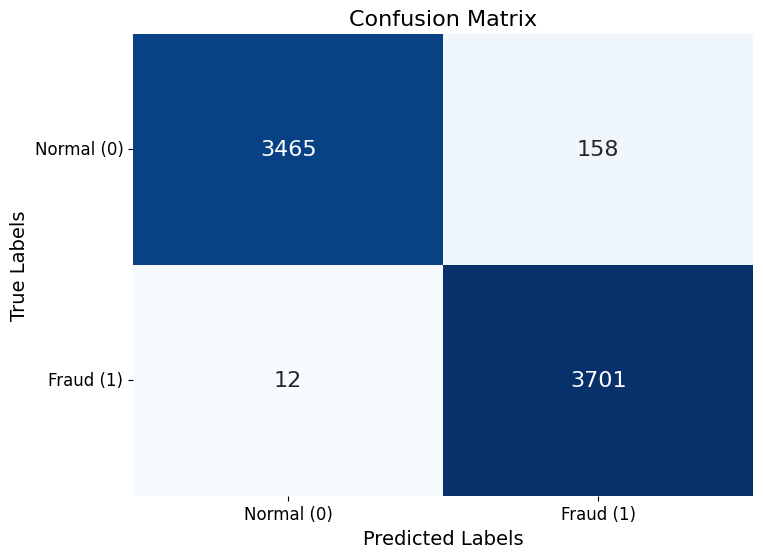

<ipython-input-11-e6d4f850b62a>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


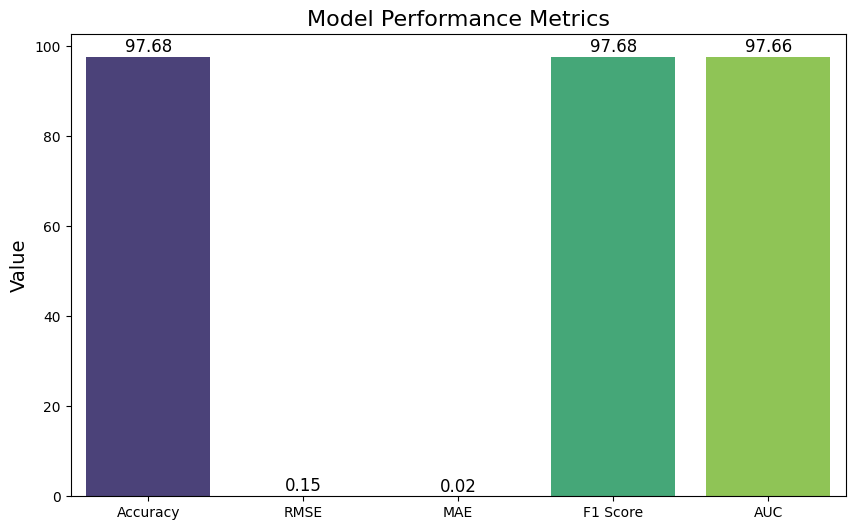

In [ ]:
# ----Main----
X_train, X_test, y_train, y_test = read_data()

# Uncomment any model to test
# ANN(X_train, X_test, y_train, y_test)
# model = CNN1D(X_train, X_test, y_train, y_test)
model = CNN2D(X_train, X_test, y_train, y_test)
# RF(X_train, X_test, y_train, y_test)
# LR(X_train, X_test, y_train, y_test)
# DT(X_train, X_test, y_train, y_test)
# model = XGB(X_train, X_test, y_train, y_test)
# SVM(X_train, X_test, y_train, y_test)

In [ ]:
# Assuming 'model' is your trained Keras model
model.save('trained_model_2D.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('trained_model_2D.h5')

230/230 [==============================] - 19s 78ms/step
Accuracy: 98.00%
RMSE: 0.1416
MAE: 0.0200
F1 Score (Weighted): 98.00%
AUC: 97.98%


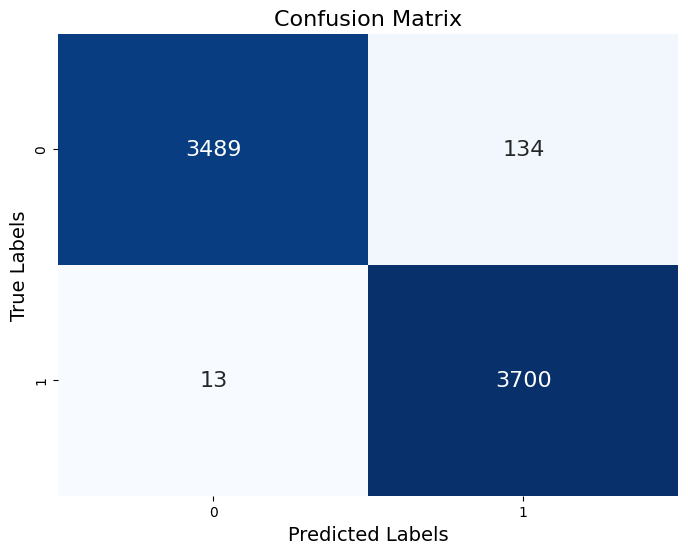

<ipython-input-15-12bda57e6493>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


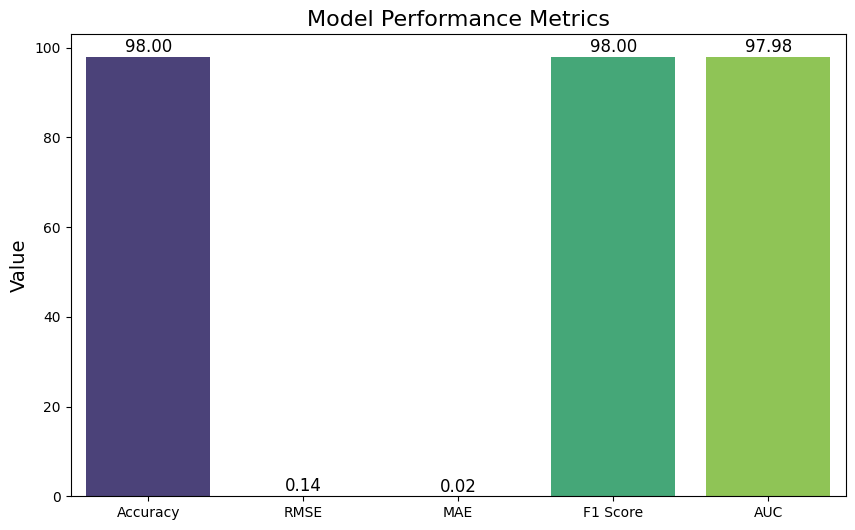

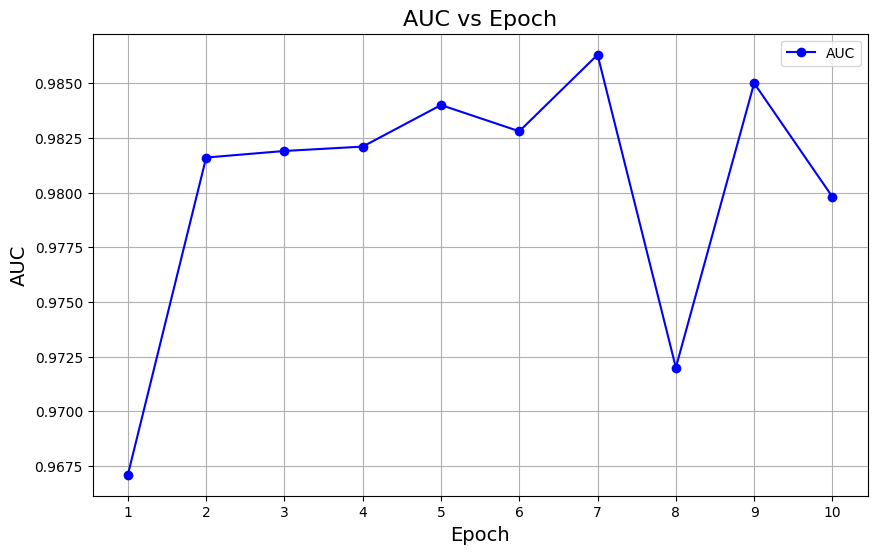

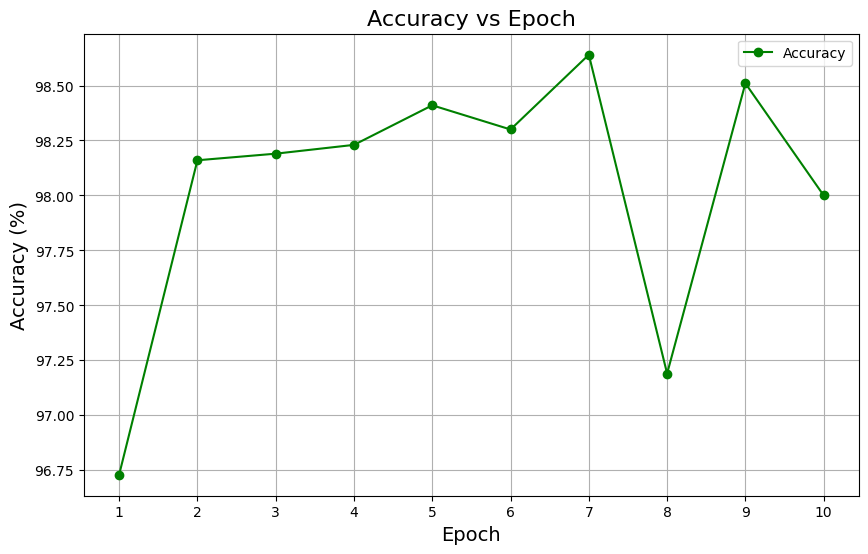

In [ ]:
# AUC per epoch
auc_per_epoch = [0.9671, 0.9816, 0.9819, 0.9821, 0.9840, 0.9828, 0.9863, 0.9720, 0.9850, 0.9798]

# Accuracy per epoch (converted to percentages as they are between 0 and 1 in your logs)
accuracy_per_epoch = [96.73, 98.16, 98.19, 98.23, 98.41, 98.30, 98.64, 97.19, 98.51, 98.00]

# Number of epochs
epochs_number = 10

# Predict using the loaded model
predictions_prob = model.predict(X_test)
predictions = (predictions_prob > 0.5).astype("int32")

# Call the results_CNN function with the provided values
results_CNN(y_test, predictions, auc_per_epoch, accuracy_per_epoch, epochs=epochs_number,
            save_folder='/content/drive/MyDrive/Power_Theft_Detection/resultsImages')



# **Prediction Functions**

## Process Input

In [ ]:
def preprocess_input(input_data):
    # rawData = input_data

    infoData = pd.DataFrame()
    infoData['FLAG'] = rawData['FLAG']
    infoData['CONS_NO'] = rawData['CONS_NO']
    data = rawData.drop(['FLAG', 'CONS_NO'], axis=1)

    # data = input_data

    dropIndex = data[data.duplicated()].index  # duplicates drop
    data = data.drop(dropIndex, axis=0)
    # infoData = infoData.drop(dropIndex, axis=0)

    zeroIndex = data[(data.sum(axis=1) == 0)].index  # zero rows drop
    data = data.drop(zeroIndex, axis=0)
    # infoData = infoData.drop(zeroIndex, axis=0)

    # data.columns = pd.to_datetime(data.columns)  # columns reindexing according to dates
    # data = data.reindex(sorted(data.columns), axis=1)
    cols = data.columns

    data.reset_index(inplace=True, drop=True)  # index sorting
    # infoData.reset_index(inplace=True, drop=True)

    data = data.interpolate(method='linear', limit=2,  # filling NaN values
                            limit_direction='both', axis=0).fillna(0)

    for i in range(data.shape[0]):  # outliers treatment
        m = data.loc[i].mean()
        st = data.loc[i].std()
        data.loc[i] = data.loc[i].mask(data.loc[i] > (m + 3 * st), other=m + 3 * st)

    scale = MinMaxScaler()
    scaled = scale.fit_transform(data.values.T).T
    mData = pd.DataFrame(data=scaled, columns=data.columns)
    preprData = pd.concat([infoData, mData], axis=1, sort=False)  # Back to initial format


    # Setting the target and dropping the unnecessary columns
    y = preprData[['FLAG']]
    X = preprData.drop(['FLAG', 'CONS_NO'], axis=1)

    # columns reindexing according to dates
    # X.columns = pd.to_datetime(X.columns)
    # X = X.reindex(X.columns, axis=1)

    # Splitting the dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y['FLAG'], test_size=0.5, random_state=0)
    return  X_test, y_test

## Predict

In [ ]:
def predict(input_data, model):
    # Ensure the input data is reshaped to match the model's expected input shape
    if len(input_data.shape) == 2:
        # Reshape from (batch_size, 1036, 1) to (batch_size, 148, 7, 1)
        input_data = input_data.reshape((input_data.shape[0], 148, 7, 1))

    # Perform prediction
    prediction = model.predict(input_data)

    # Convert probabilities to binary predictions
    binary_prediction = (prediction > 0.5).astype("int32")

    return binary_prediction


## Load Model

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('trained_model.h5')

## Take sample inputs

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Power_Theft_Detection/Dataset/data.csv')

In [ ]:
# df = df.iloc[:, -30:]

In [ ]:
# df.columns.values[-30:] = [f"day{i}" for i in range(1, 31)]

In [ ]:
sampled_df = df.sample(n=3000)

In [ ]:
sampled_df.shape

(3000, 1036)

In [ ]:
sampled_df.head()

,CONS_NO,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
7392,D73835C222213642C11952777DCDCBDE,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.71,6.46,5.09,6.57,4.47,5.64,2.89,4.47,5.00,4.30
37360,3D11A00446B370369325CEEDF4B301BE,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.09,6.43,6.68,5.34,9.12,8.81,8.26,8.35,8.98,10.48
22517,AEEA440A8C84F51B9B1ACF5656F5AFF1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.13,2.28,3.24,2.07,2.40,3.32,3.52,2.47,3.39,2.30
21729,C37C79063FE7739CACC59536970701CF,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.00,2.15,2.46,3.54,2.69,2.33,2.25,2.26,2.36,2.39
38261,E1615CDF7140EFB24ADB8AC2B8B3E221,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.96,0.87,0.89,0.88,0.89,0.90,0.88,0.89,0.88,0.86


## Generate Predictions

In [ ]:
# Preprocess the input data
# print(inputData)

def pad_input_data(input_data, target_length=1036):
    # Pad the input data to reach the required target length of 1036
    current_length = input_data.shape[1]
    if current_length < target_length:
        # Pad with zeros
        padding = np.zeros((input_data.shape[0], target_length - current_length))
        input_data = np.hstack((input_data, padding))  # No need for .to_numpy() as it's already a numpy array
    return input_data

# Call the padding function before prediction
X_test_padded = pad_input_data(X_test, target_length=148*7)  # Target length = 1036

# Then reshape and predict
predictions = predict(X_test_padded, model)


# X_test, y_test = preprocess_input(sampled_df)

# # Perform prediction using the updated predict function
# predictions = predict(X_test, model)
# labels = y_test

663/663 [==============================] - 15s 22ms/step


In [ ]:
predictions

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

Accuracy: 99.07%
RMSE: 0.0967
MAE: 0.0093
F1 Score (Weighted): 99.08%
AUC: 98.64%


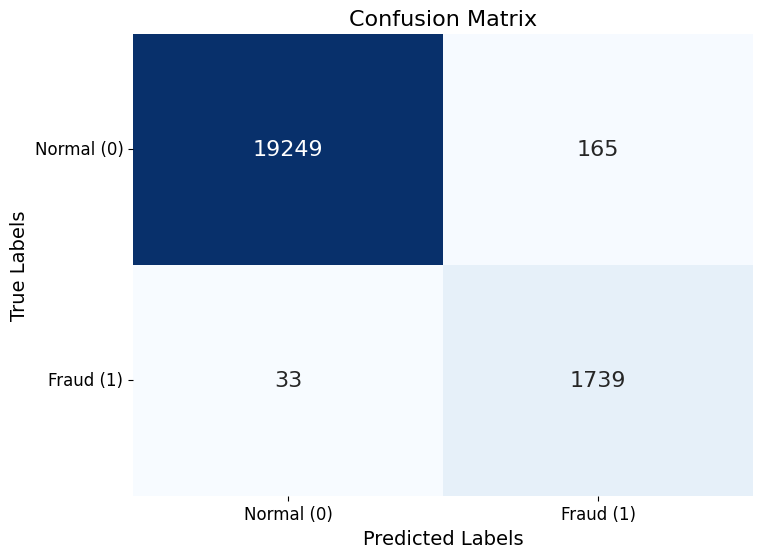

<ipython-input-11-e6d4f850b62a>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


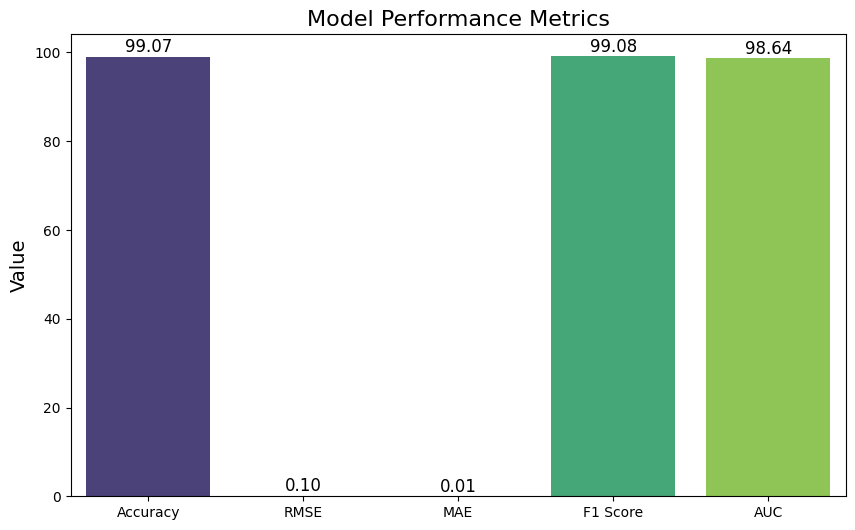

In [ ]:
results(y_test, predictions, save_folder='/content/drive/MyDrive/Power_Theft_Detection/resultsImages')

## pickle file

In [ ]:
### create a pickle file using serialization
#import pickle
#pickle_out = open("classifier.pkl","wb")
#pickle.dump(classifier, pickle_out)
#pickle_out.close()

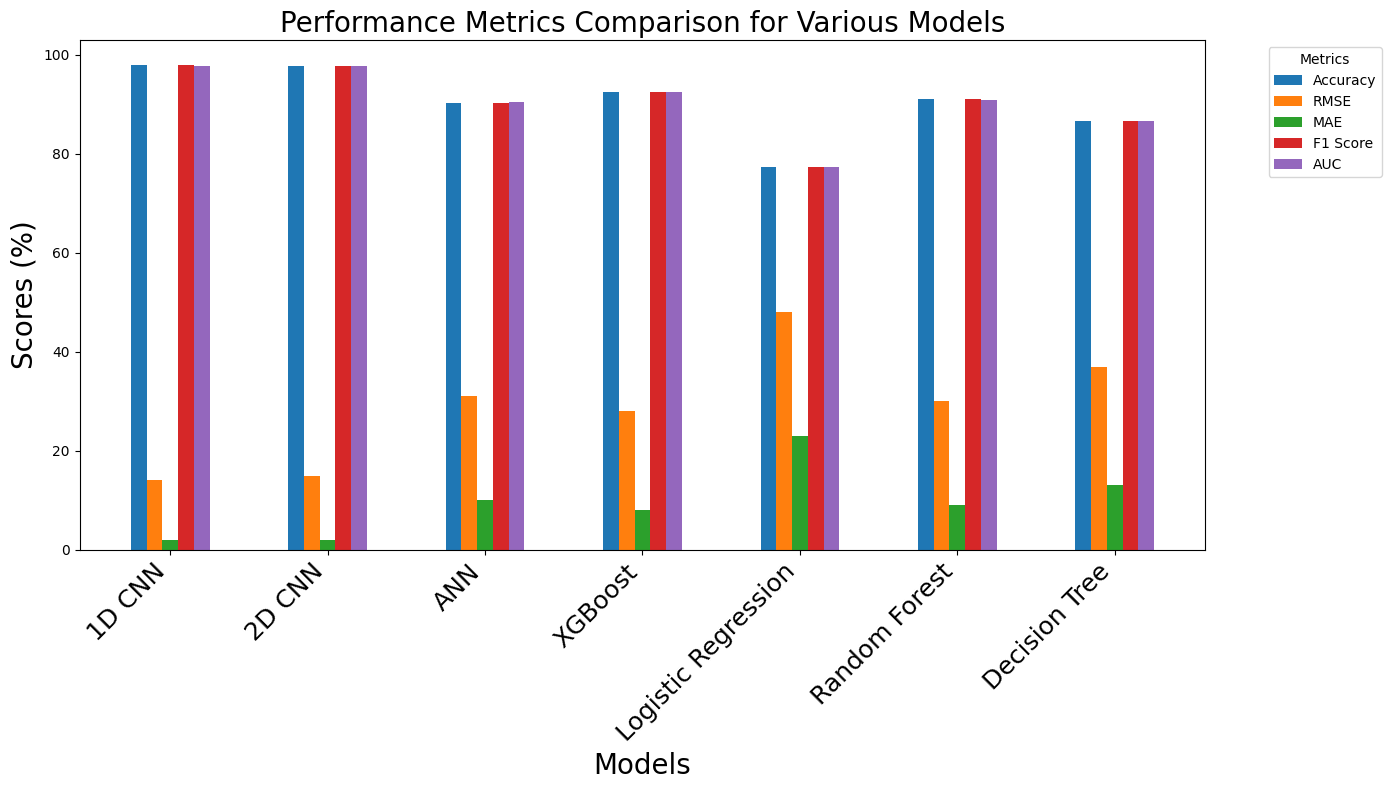

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os

# Data for the models
model_names = ['1D CNN', '2D CNN', 'ANN', 'XGBoost', 'Logistic Regression', 'Random Forest', 'Decision Tree']
metrics = ['Accuracy', 'RMSE', 'MAE', 'F1 Score', 'AUC']

# Performance values for each model
values = [
    [98.00, 0.14, 0.02, 98.00, 97.78],  # 1D CNN
    [97.68, 0.15, 0.02, 97.68, 97.66],  # 2D CNN
    [90.28, 0.31, 0.10, 90.25, 90.35],  # ANN
    [92.41, 0.28, 0.08, 92.40, 92.39],  # XGBoost
    [77.36, 0.48, 0.23, 77.33, 77.32],  # Logistic Regression
    [90.96, 0.30, 0.09, 90.96, 90.94],  # Random Forest
    [86.64, 0.37, 0.13, 86.63, 86.61]   # Decision Tree
]

# Convert to DataFrame for easier plotting
df = pd.DataFrame(values, columns=metrics, index=model_names)

# Normalize the values (optional: you can scale them differently depending on your preferences)
df_normalized = df.copy()
df_normalized['RMSE'] = df['RMSE'] * 100  # Scale RMSE to be on the same range as others
df_normalized['MAE'] = df['MAE'] * 100  # Scale MAE to be on the same range as others

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Set the width of the bars
bar_width = 0.1

# Define the positions for the bars on the x-axis
positions = np.arange(len(model_names))  # Base positions for each model

# Plot each metric with an offset from the base positions to create groups
for i, metric in enumerate(metrics):
    ax.bar(positions + i * bar_width, df_normalized[metric], width=bar_width, label=metric)

# Adjusting the x-ticks to be in the center of the grouped bars
ax.set_xticks(positions + bar_width * 2)  # Adjust the position to center the labels
ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=18)

# Set the labels and title
ax.set_title('Performance Metrics Comparison for Various Models', fontsize=20)
ax.set_xlabel('Models', fontsize=20)
ax.set_ylabel('Scores (%)', fontsize=20)

# Add a legend
ax.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')

# Tight layout for better spacing
plt.tight_layout()

# Save the plot as a PDF with bbox_inches='tight' to avoid cropping
save_folder='/content/drive/MyDrive/Power_Theft_Detection/resultsImages'
comparison_pdf_path = os.path.join(save_folder, 'comparison_of_models.pdf')
plt.savefig(comparison_pdf_path, format='pdf', bbox_inches='tight')  # Use bbox_inches='tight' to avoid cropping

# Show the plot
plt.show()
